In [ ]:
# !pip install torchcam
# !pip install opencv-python


### Importing Necessary Libraries for Model Development and Evaluation


In [34]:
import os
import random
import copy
import glob
import datetime
from collections import defaultdict

import torch
import torch.nn as nn
import torch.optim as optim
import torchcam
import mlflow
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torch.optim.lr_scheduler import ExponentialLR
from torchvision.models import resnet18
from torchvision import transforms, models, datasets
from torchvision.datasets import ImageFolder
from sklearn.metrics import classification_report, confusion_matrix

from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image


### Hyperparameters Initialization

In [36]:
# Hyperparameters
IMG_SIZE = (256, 256)
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.001
NUM_WORKERS = 2
experiment_name = "Plant Disease identification"

RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# Set GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


Using device: cuda:0


### Defining Dataset Path and Applying Data Transformations for Training and Testing

In [ ]:
# Path to dataset
DATA_DIR = "/work/TALC/enel645_2025w/plant_dataset/plantvillage_dataset/color"

# Transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(), 
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


### Loading and Splitting the Dataset into Training, Validation, and Test Sets

In [ ]:
# Load dataset without transforms first
full_dataset = datasets.ImageFolder(root=DATA_DIR, transform=None)
class_names = full_dataset.classes
num_classes = len(class_names)
print("Classes:", class_names)

# Split Dataset
dataset_size = len(full_dataset)
train_ratio, val_ratio, test_ratio = 0.7, 0.15, 0.15

train_size = int(train_ratio * dataset_size)
val_size = int(val_ratio * dataset_size)
test_size = dataset_size - train_size - val_size

train_subset, val_subset, test_subset = random_split(
    full_dataset,
    lengths=[train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(RANDOM_SEED)
)


Classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___

### Applying transformations to each dataset subset and wrapping them into DataLoaders.



In [ ]:
def apply_transform(subset, transform):
    subset.dataset = copy.deepcopy(subset.dataset)
    subset.dataset.transform = transform
    return subset

train_subset = apply_transform(train_subset, train_transform)
val_subset = apply_transform(val_subset, train_transform)
test_subset = apply_transform(test_subset, test_transform)

# Create Dataloaders
train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

print(f"Train: {len(train_subset)}, Val: {len(val_subset)}, Test: {len(test_subset)}")


Train: 38013, Val: 8145, Test: 8147


### Fetching a batch of images and labels from the training loader and visualizing one example. 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.2216995].


Image batch shape: torch.Size([32, 3, 224, 224])
Label batch shape: torch.Size([32])


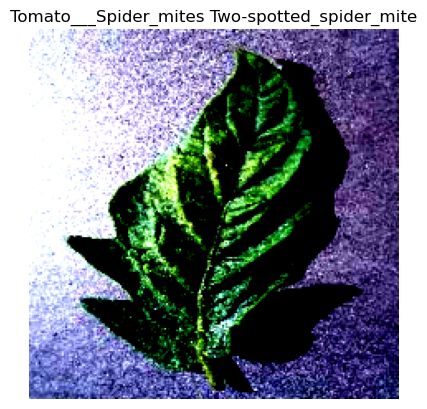

In [ ]:
train_iterator = iter(train_loader)
images, labels = next(train_iterator)

print("Image batch shape:", images.size())
print("Label batch shape:", labels.size())

# Visualize one example
plt.imshow(images[0].permute(1, 2, 0).numpy())
plt.title(class_names[labels[0]])
plt.axis('off')
plt.show()


### Defining a custom PlantModel using DenseNet121 as the backbone.


In [ ]:
class PlantModel(nn.Module):
    def __init__(self, num_classes, input_shape=(3, 224, 224), transfer=False):
        super().__init__()
        self.transfer = transfer
        self.densenet = models.densenet121(pretrained=transfer)

        if self.transfer:
            for param in self.densenet.features.parameters():
                param.requires_grad = False

        n_features = self.densenet.classifier.in_features
        self.densenet.classifier = nn.Identity()
        self.classifier = nn.Linear(n_features, num_classes)

    def forward(self, x):
        features = self.densenet(x)
        out = self.classifier(features)
        return out

net = PlantModel(num_classes, (3, 224, 224), transfer=True)
net.to(device);


/home/laxmi.paudel/software/miniforge3/envs/pytorch-ensf645/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/laxmi.paudel/software/miniforge3/envs/pytorch-ensf645/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Setting up loss function, optimizer (AdamW), and learning rate scheduler (ExponentialLR).


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(net.parameters(), lr=LEARNING_RATE)
scheduler = ExponentialLR(optimizer, gamma=0.9)

nepochs = EPOCHS
PATH = './Plant_class_DesNet.pth'  # Save best model here


### Model training with Early Stopping and Model Checkpointing

In [ ]:
best_loss = 1e+20
patience = 5 
all_train_losses = []  
all_val_losses = []    
epochs_without_improvement = 0 

for epoch in range(nepochs):
    net.train()
    train_loss, correct_train, total_train = 0, 0, 0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        predictions = outputs.argmax(dim=1)
        correct_train += (predictions == labels).sum().item()
        total_train += labels.size(0)

    train_acc = correct_train / total_train
    train_loss /= len(train_loader)
    scheduler.step()

    # Validation
    net.eval()
    val_loss, correct_val, total_val = 0, 0, 0
    with torch.no_grad():
        for i, data in enumerate(val_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            predictions = outputs.argmax(dim=1)
            correct_val += (predictions == labels).sum().item()
            total_val += labels.size(0)
    val_acc = correct_val / total_val
    val_loss /= len(val_loader)

    # Save the losses for plotting later
    all_train_losses.append(train_loss)
    all_val_losses.append(val_loss)

    print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    if val_loss < best_loss:
        print("Saving model...")
        torch.save(net.state_dict(), PATH)
        best_loss = val_loss
        epochs_without_improvement = 0  # reset counter if improvement is found
    else:
        epochs_without_improvement += 1

    # Early stopping condition
    if epochs_without_improvement >= patience:
        print(f"Early stopping after {epoch + 1} epochs due to no improvement in validation loss.")
        break

print('Finished Training')


Epoch 1: Train Loss: 0.5492, Train Acc: 0.8794 | Val Loss: 0.1841, Val Acc: 0.9543
Saving model...
Epoch 2: Train Loss: 0.1782, Train Acc: 0.9526 | Val Loss: 0.1264, Val Acc: 0.9655
Saving model...
Epoch 3: Train Loss: 0.1370, Train Acc: 0.9614 | Val Loss: 0.1175, Val Acc: 0.9664
Saving model...
Epoch 4: Train Loss: 0.1175, Train Acc: 0.9658 | Val Loss: 0.0937, Val Acc: 0.9721
Saving model...
Epoch 5: Train Loss: 0.1033, Train Acc: 0.9696 | Val Loss: 0.0914, Val Acc: 0.9710
Saving model...
Epoch 6: Train Loss: 0.0964, Train Acc: 0.9708 | Val Loss: 0.0873, Val Acc: 0.9730
Saving model...
Epoch 7: Train Loss: 0.0914, Train Acc: 0.9721 | Val Loss: 0.0806, Val Acc: 0.9736
Saving model...
Epoch 8: Train Loss: 0.0850, Train Acc: 0.9740 | Val Loss: 0.0716, Val Acc: 0.9770
Saving model...
Epoch 9: Train Loss: 0.0782, Train Acc: 0.9764 | Val Loss: 0.0764, Val Acc: 0.9753
Epoch 10: Train Loss: 0.0759, Train Acc: 0.9771 | Val Loss: 0.0756, Val Acc: 0.9759
Epoch 11: Train Loss: 0.0750, Train Acc: 

### Plotting Training and Validation Losses Over Epochs

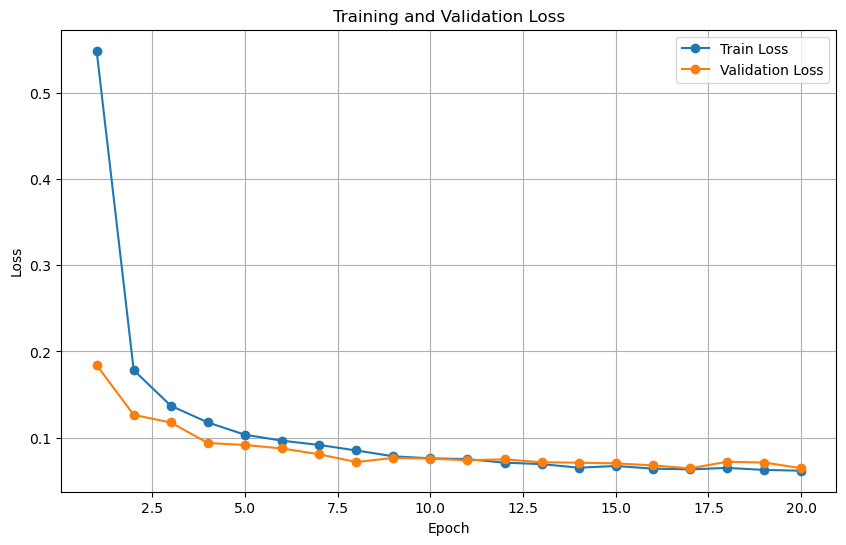

In [ ]:

# Create a figure and plot the losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(all_train_losses) + 1), all_train_losses, label='Train Loss', marker='o')
plt.plot(range(1, len(all_val_losses) + 1), all_val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

### Model Testing and Accuracy Evaluation on Test Set


In [ ]:
net = PlantModel(num_classes, (3,224,224), False)
net.load_state_dict(torch.load(PATH))
net.to(device)

print("Model loaded. Starting testing...")

correct, total = 0, 0
all_preds, all_labels = [], []

net.eval()
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())   
        all_labels.extend(labels.cpu().numpy())     

print(f'Accuracy of the network on the test images: {100 * correct / total:.2f}%')


/home/laxmi.paudel/software/miniforge3/envs/pytorch-ensf645/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Model loaded. Starting testing...
Accuracy of the network on the test images: 97.50%


### Generating Classification Report and Confusion Matrix



Classification Report:
                                                     precision    recall  f1-score   support

                                Apple___Apple_scab       0.97      0.97      0.97        91
                                 Apple___Black_rot       1.00      0.99      0.99        87
                          Apple___Cedar_apple_rust       1.00      0.97      0.99        37
                                   Apple___healthy       0.99      0.99      0.99       270
                               Blueberry___healthy       0.97      1.00      0.99       198
          Cherry_(including_sour)___Powdery_mildew       0.98      0.99      0.99       176
                 Cherry_(including_sour)___healthy       0.99      1.00      1.00       125
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.79      0.93      0.85        71
                       Corn_(maize)___Common_rust_       0.99      1.00      1.00       168
               Corn_(maize)___Northern_Leaf_Blight    

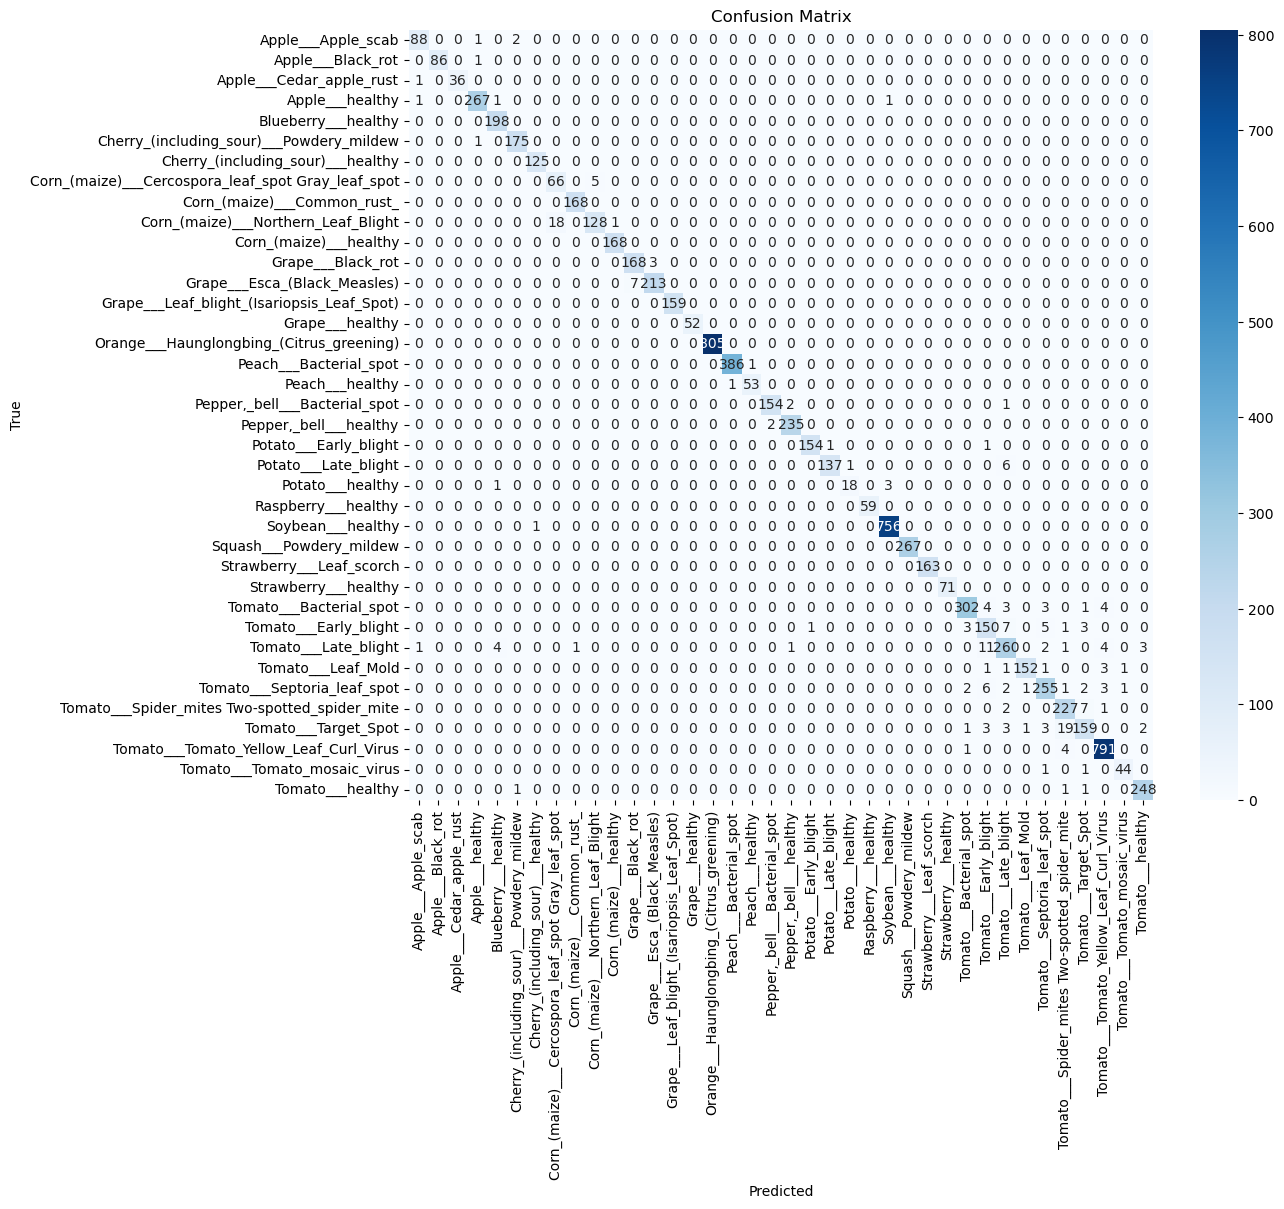

In [ ]:
# Report
report = classification_report(all_labels, all_preds, target_names=class_names)
print("\nClassification Report:\n", report)

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)

plt.figure(figsize=(12, 10))
sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


### Applying Grad-CAM for Visualizing Class Activation Maps


In [ ]:

def apply_gradcam(model, image, target_class=None, device='cuda'):
    model.eval()

    input_tensor = image.unsqueeze(0).to(device)

    # Use a broader conv layer for meaningful CAM
    target_layer = model.densenet.features.denseblock4

    # Use GradCAM with context manager to auto-clear hooks
    with GradCAM(model=model.densenet, target_layers=[target_layer]) as cam:
        output = model(input_tensor)

        if target_class is None:
            target_class = output.argmax(dim=1).item()

        grayscale_cam = cam(input_tensor=input_tensor, targets=None)
        grayscale_cam = grayscale_cam[0]

        # Convert image to NumPy, make sure it's in [0,1] range
        image_np = image.cpu().numpy().transpose(1, 2, 0).astype(np.float32)
        
        # Ensure valid range by normalizing min-max (fix black image issue)
        image_np -= image_np.min()  # Shift min to 0
        image_np /= image_np.max()  # Scale max to 1

        cam_image = show_cam_on_image(image_np, grayscale_cam, use_rgb=True)

        # Plotting
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(image_np)
        plt.title("Original Image")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(cam_image)
        plt.title("Grad-CAM")
        plt.axis("off")
        plt.show()


In [ ]:
# !pip install grad-cam


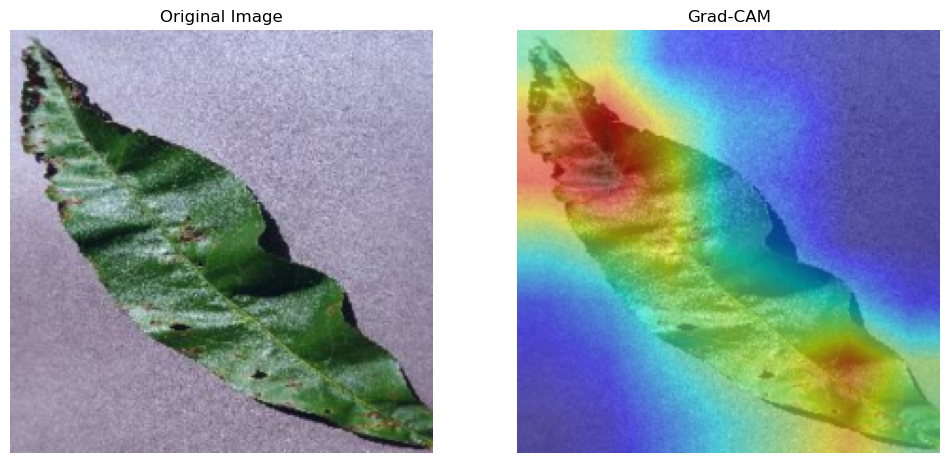

In [64]:
image, label = next(iter(test_loader))
apply_gradcam(net, image[8], target_class=label[0].item())